### AdaBoost

En este notebook utilizaremos AdaBoostClassifier para entrenar y predecir sobre el dataset de entrenamiento, con dos preprocesamientos distintos: uno muy similar al realizado en la parte 1 de este TP pero escalando los datos, y el segundo será el resultado de la función `preprocessing_significantes`. Estos dos preprocesamientos los usaremos con un modelo de AdaBoost con `base_estimator` default (árboles). Luego, cambiaremos ese estimador por un MultinomialNB, y lo usaremos con los preprocesamientos de la parte 1 del TP y el equilibrado.

In [1]:
# Modelo 
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier

# Preprocessing
import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Búsqueda
from sklearn.model_selection import train_test_split, GridSearchCV

# Metrics 
from sklearn.metrics import roc_curve, plot_roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, plot_confusion_matrix

# Plots
from matplotlib import pyplot as plt

#Otros
import pandas as pd
import numpy as np
import utils

Esta vez, usaremos una instancia del SimpleImputer de sklearn para rellenar los valores faltantes, utilizando la estrategia de utilizar el valor más frecuente en cada columna.

In [2]:
imputer = SimpleImputer(strategy='most_frequent')
df = utils.get_data()
df_imp = pd.DataFrame(imputer.fit_transform(df[['ganancia_perdida_declarada_bolsa_argentina', 'edad', 'rol_familiar_registrado', 'anios_estudiados']]))


Creamos las variables dummy, separamos la columna de valor adquisitivo, y separamos el dataset en training y test.

In [3]:
X = df_imp
X = pd.get_dummies(X)
Y = df['tiene_alto_valor_adquisitivo']

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=112)

Usamos GridSearchCV con los siguientes hiperparámetros, y entrenamos los modelos

In [4]:
params = { 'n_estimators':range(100,501,100), 'learning_rate': np.linspace(0.1, 5, 10), 'algorithm': ('SAMME', 'SAMME.R') }
model = AdaBoostClassifier()

In [5]:
gscv = GridSearchCV(model, params, scoring='roc_auc', cv=4, n_jobs=-1, verbose=10)

In [6]:
%%time
gscv.fit(X_train, y_train)
score = roc_auc_score(y_test, gscv.predict_proba(X_test)[:,1])

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 16

CPU times: user 35.1 s, sys: 451 ms, total: 35.6 s
Wall time: 54min 56s


Analicemos lo obtenido:

In [9]:
gscv.best_params_

{'algorithm': 'SAMME.R',
 'learning_rate': 0.6444444444444445,
 'n_estimators': 300}

In [10]:
score

0.9188260257306489

In [11]:
print(classification_report(y_test,gscv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      6182
           1       0.81      0.55      0.66      1959

    accuracy                           0.86      8141
   macro avg       0.84      0.76      0.78      8141
weighted avg       0.86      0.86      0.85      8141



Vemos muy buenos resultados en términos de accuracy. También tenemos una buena performance en la clasificación de muestras que no tienen poder adquisitivo alto, y un desempeño decente (en comparación con lo visto en otros modelos) para clasificar casos de poder adquisitivo alto. En líneas generales, es claramente superador a lo realizado en la parte 1 del TP.

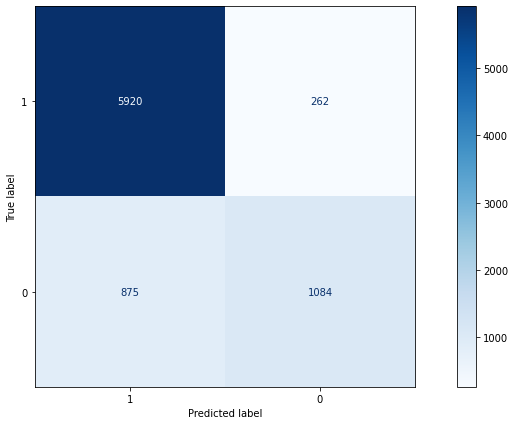

In [12]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(gscv, X_test, y_test, cmap=plt.cm.Blues, display_labels=['1', '0'], ax=ax)
plt.show()

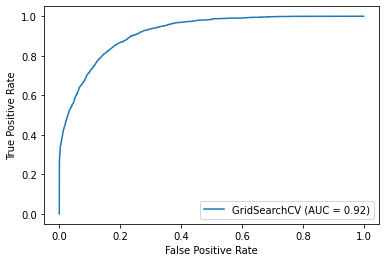

In [13]:
plot_roc_curve(gscv, X_test, y_test)

La métrica AUC-ROC se encuentra entre las mejores que obtuvimos hasta ahora.

### AdaBoost con Bayes

Estudiemos qué resulta de cambiar el base_estimator (que por default es un árbol) a MultinomialNB, repitiendo el procedimiento anterior.

In [14]:
multinomialNB = MultinomialNB(alpha=0.1402805611222445)
model_nb = AdaBoostClassifier(base_estimator=multinomialNB)

In [15]:
gscv_nb = GridSearchCV(model_nb, params, scoring='roc_auc', cv=4, n_jobs=-1, verbose=10)

In [16]:
%%time
gscv_nb.fit(X_train, y_train)
score = roc_auc_score(y_test, gscv_nb.predict_proba(X_test)[:,1])

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 15

CPU times: user 2min 33s, sys: 1min 28s, total: 4min 2s
Wall time: 1h 5min 28s


In [17]:
gscv_nb.best_params_

{'algorithm': 'SAMME.R',
 'learning_rate': 0.6444444444444445,
 'n_estimators': 500}

In [18]:
score

0.9127565596177478

In [19]:
print(classification_report(y_test,gscv_nb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      6182
           1       0.79      0.55      0.65      1959

    accuracy                           0.86      8141
   macro avg       0.83      0.75      0.78      8141
weighted avg       0.85      0.86      0.85      8141



Vemos que la mejor combinación de hiperparámetros obtenida utiliza el mismo algoritmo y el mismo learning rate que en el caso anterior, pero aumentó la cantidad de estimadores. Sin embargo, esto no llevó a un aumento apreciable en la performance del modelo sobre el dataset utilizado.

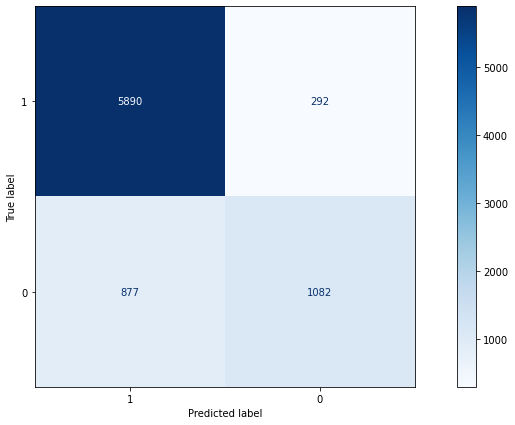

In [20]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(gscv_nb, X_test, y_test, cmap=plt.cm.Blues, display_labels=['1', '0'], ax=ax)
plt.show()

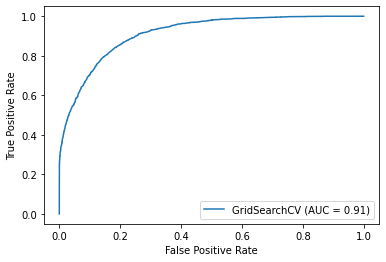

In [21]:
plot_roc_curve(gscv_nb, X_test, y_test)

La métrica AUC-ROC empeoró ligeramente.

### AdaBoost con `preprocessing_significantes`

Para finalizar, veamos qué obtenemos al cambiar el preprocesamiento por el realizado con la función `preprocessing_significantes`

In [22]:
df, pa = preprocessing.preprocessing_significantes(utils.feature_engineering(utils.get_data()))

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df, pa, random_state=112)

In [24]:
params = { 'n_estimators':range(100,501,100), 'learning_rate': np.linspace(0.1, 5, 10), 'algorithm': ('SAMME', 'SAMME.R') }
model = AdaBoostClassifier()

In [25]:
gscv = GridSearchCV(model, params, scoring='roc_auc', cv=4, n_jobs=-1, verbose=10)

In [26]:
%%time
gscv.fit(X_train, y_train)
score = roc_auc_score(y_test, gscv.predict_proba(X_test)[:,1])

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 15

CPU times: user 59.5 s, sys: 353 ms, total: 59.8 s
Wall time: 36min 10s


In [27]:
gscv.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 500}

In [28]:
score

0.8964718165287124

In [29]:
print(classification_report(y_test,gscv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      6182
           1       0.71      0.56      0.63      1959

    accuracy                           0.84      8141
   macro avg       0.79      0.74      0.76      8141
weighted avg       0.83      0.84      0.83      8141



Nuevamente, obtenemos el mismo algoritmo y el learning_rate, pero esta vez con una disminución en la cantidad de estimadores utilizados. En cuanto a las métricas obtenidas, esta configuración nos llevó a la peor performance de las tres analizadas para este clasificador.

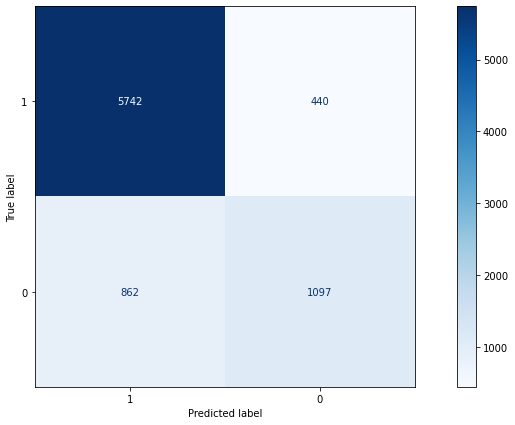

In [30]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(gscv, X_test, y_test, cmap=plt.cm.Blues, display_labels=['1', '0'], ax=ax)
plt.show()

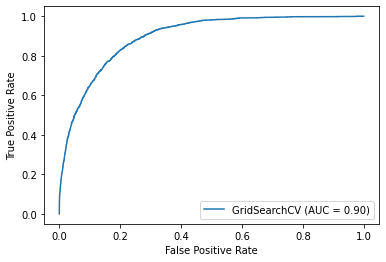

In [31]:
plot_roc_curve(gscv, X_test, y_test)

Si bien es mejor que la mayoría de las clasificaciones obtenidas usando otros modelos, esta es la que peor AUC-ROC presenta para AdaBoost.